In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications import resnet_v2
import os
import numpy as np
import random
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
anchor_img_path="../input/fashion-final/crop_fin1"
positive_img_path="../input/fashion-final/product_img"
target_shape=(224,224)

In [4]:
import pickle
f1=open('../input/fashion-final/catmatch3e.txt','rb')
data=f1.read()
catmatch=pickle.loads(data)

In [ ]:
pic1=

In [5]:
def preprocess_image(img_path):
    image_string = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image,(224,224))
    return image
def preprocess_triplets(anchor,positive,negative):
    return (preprocess_image(anchor),preprocess_image(positive),preprocess_image(negative))

In [6]:
anchor_images=([anchor_img_path+'/'+f for f in os.listdir(anchor_img_path)])
anchor_images=sorted(anchor_images,key=lambda x:int(x[41:].rstrip('.png')))
positive_images=([positive_img_path+'/'+d for d in os.listdir(positive_img_path)])
positive_images=sorted(positive_images,key=lambda x:int(x[42:].rstrip('.png')))
image_count=len(anchor_images)
anchor_dataset=tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset=tf.data.Dataset.from_tensor_slices(positive_images)

#generating the negative images

def generate_neg(positive_img):
    prod_no=int(positive_img[42:].rstrip('.png'))
    for x in catmatch.keys():
        if prod_no in catmatch[x]:
            sel_list=catmatch[x].copy()
    sel_list.remove(prod_no)
    neg_no=sel_list[random.randint(0,len(sel_list)-1)]
    neg_img=positive_img[0:42]+str(neg_no)+'.png'
    return neg_img
negative_images=[generate_neg(x) for x in positive_images]
negative_dataset=tf.data.Dataset.from_tensor_slices(negative_images)

In [18]:
image_count

68941

In [45]:
dataset=tf.data.Dataset.zip((anchor_dataset,positive_dataset,negative_dataset))
dataset=dataset.shuffle(buffer_size=1024)
dataset=dataset.map(preprocess_triplets)

train_dataset=dataset.take(round(image_count*0.2))
val_dataset=dataset.take(round(image_count*0.2))

# train_dataset=train_dataset.batch(8,drop_remainder=False)
# val_dataset = val_dataset.batch(8, drop_remainder=False)

In [46]:
train_dataset=train_dataset.batch(8,drop_remainder=False)
val_dataset = val_dataset.batch(8, drop_remainder=False)

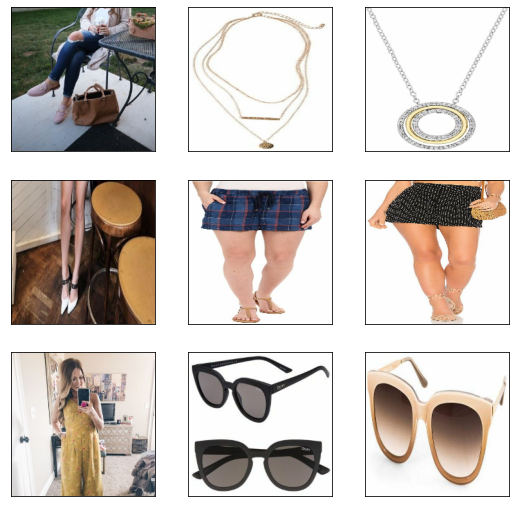

In [8]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [9]:
base_model=ResNet50V2(weights='imagenet',input_shape=(224,224) + (3,),include_top=False)

dense1=layers.Dense(units=1024)(base_model.output)
dense1=layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(dense1)
dense1=layers.Activation('relu')(dense1)
dense1=layers.Dropout(.25)(dense1)
output=layers.Dense(units=128,activity_regularizer=tf.keras.regularizers.l2(0.01))(dense1)

# fan it out to all of the channels
'''up_c2_w = np.ones((1, 1, 1, 128))
up_c2 = layers.Conv2D(1, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)'''
embedding = Model(base_model.input, output, name="Embedding")

trainable = False
for layer in base_model.layers:
    if layer.name == "conv4_block6_out":
        trainable = True
    layer.trainable = trainable

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
# list_of_layers=embedding.layers
# for x in range(-1,-6,-1):
#     print(list_of_layers[x])

In [10]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet_v2.preprocess_input(anchor_input)),
    embedding(resnet_v2.preprocess_input(positive_input)),
    embedding(resnet_v2.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [11]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [52]:
siamese_model.built=True

In [53]:
#code for resuming training from last checkpoint
# siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.load_weights('../input/saved-weight1/siamese_ver1.h5')

In [ ]:
siamese_model.summary()

In [48]:
siamese_model = SiameseModel(siamese_network)
# siamese_model.compile(optimizer=optimizers.Adam(0.0001))
# siamese_model.fit(train_dataset, epochs=1)

In [49]:
siamese_model.compile(optimizer=optimizers.Adam(0.001))

In [50]:
# siamese_model.compile(optimizer=optimizers.Adam(0.001))
siamese_model.fit(train_dataset, epochs=2)

Epoch 1/2
  47/1724 [..............................] - ETA: 4:47 - loss: 0.5000

KeyboardInterrupt: 

In [ ]:
anchor1,positive1,negative1=list(train_dataset.take(1).as_numpy_iterator())[0]

In [ ]:
anchor_img1=anchor1[0].reshape(1,224,224,3)
positive_img1=positive1[0].reshape(1,224,224,3)
negative_img1=negative1[0].reshape(1,224,224,3)



In [ ]:
output=siamese_model((anchor_img1,positive_img1,negative_img1))

In [ ]:
output

In [ ]:
siamese_model.save("./siamese_attention1",save_format='tf')

In [ ]:
siamese_model.load_weights('../input/saved-weight1/siamese_ver1.h5')

In [ ]:
siamese_model.save("./siamese_finalsave",save_format='tf')

In [ ]:
converter=tf.lite.TFLiteConverter.from_saved_model('./siamese_finalsave')

In [ ]:
tflite_model = converter.convert()


In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
siamese_model.save_weights('./siamese_ver1.h5')

In [63]:
tf.data.Dataset(anchor)

TypeError: Can't instantiate abstract class DatasetV2 with abstract methods _inputs, element_spec

In [67]:
(sample)[0].shape

TensorShape([8, 224, 224, 3])

In [68]:
sample[1].shape

TensorShape([8, 224, 224, 3])

In [99]:
output=siamese_model(sample)

In [115]:
tf.reduce_sum(output[0][6])

<tf.Tensor: shape=(), dtype=float32, numpy=13.82659>

In [116]:
tf.reduce_sum(output[1][6])

<tf.Tensor: shape=(), dtype=float32, numpy=31.3942>

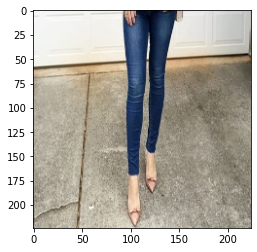

In [114]:
plt.imshow(sample[0][6])

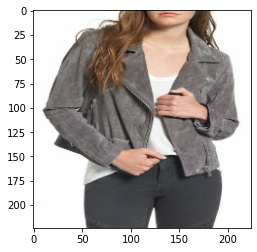

In [112]:
plt.imshow(sample[1][6])

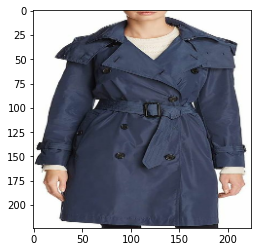

In [113]:
plt.imshow(sample[2][6])

ValueError: not enough values to unpack (expected 3, got 2)

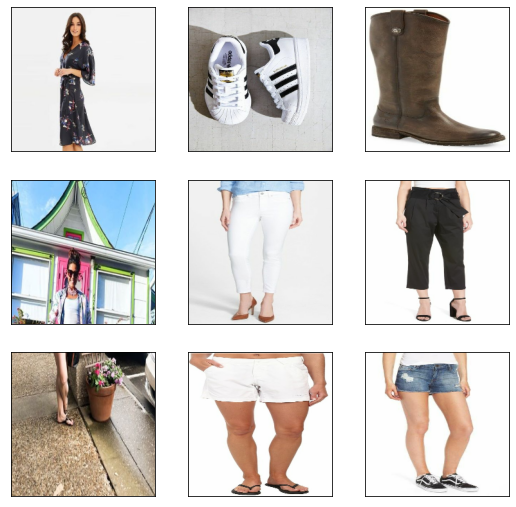

In [71]:
sample = next(iter(val_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding =siamese_model(sample)


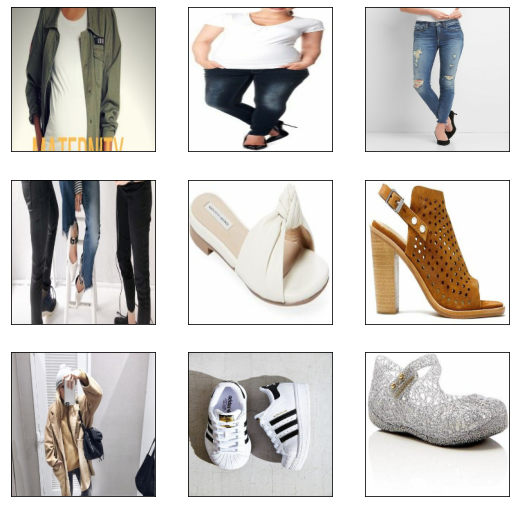

In [20]:
sample = next(iter(val_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet_v2.preprocess_input(anchor)),
    embedding(resnet_v2.preprocess_input(positive)),
    embedding(resnet_v2.preprocess_input(negative)),
)


In [ ]:
anchor_embedding

In [21]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.99999994
Negative similarity 0.99999994
